# Machine Learning Engineer Capstone Project

Stefan Langenbach  
April 2019

## Overview
* [Exploratory data analysis](Exploratory-data-analysis)
* [Feature Engineering](#Feature-Engineering)
* [Modeling](#Modeling)
* [Prediction](#Prediction)
* [Submission](#Submission)

## References
* https://www.kaggle.com/allunia/santander-customer-transaction-eda
* https://www.kaggle.com/gpreda/santander-eda-and-prediction
* https://www.kaggle.com/artgor/santander-eda-fe-fs-and-models
* https://www.kaggle.com/quanghm/fastai-1-0-tabular-learner-with-ensemble
* https://www.kaggle.com/willkoehrsen/featuretools-for-good
* https://github.com/Microsoft/LightGBM/tree/master/examples/python-guide
* https://xgboost.readthedocs.io/en/latest/python/python_intro.html
* https://github.com/dmlc/xgboost/tree/master/demo/guide-python

## Setup

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import featuretools as ft
import lightgbm as lgb
import xgboost as xgb
import featuretools as ft
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

/usr/local/anaconda3/envs/capstone/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Load data

In [2]:
# define paths
root_path = Path.home().joinpath("Code/udacity-ml-nanodegree/capstone")  # adapt this to suite your local working environment
data_path = root_path.joinpath("data")
model_path = root_path.joinpath("model")
img_path = root_path.joinpath("image")

In [3]:
# load data
train_df = pd.read_csv(f"{data_path}/train.csv")
test_df = pd.read_csv(f"{data_path}/test.csv")
sample_sub = pd.read_csv(f"{data_path}/sample_submission.csv")

## Exploratory data analysis

### Train dataset

In [4]:
train_df.shape

(200000, 202)

In [143]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [144]:
# Check missing values
train_df.isnull().any().any()

False

In [145]:
# Check distribution of classes in target column
train_df["target"].value_counts(normalize=True)

0    0.89951
1    0.10049
Name: target, dtype: float64

Get summary stats

In [146]:
train_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


### Test dataset

In [147]:
test_df.shape

(200000, 201)

In [148]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [149]:
test_df.isnull().any().any()

False

In [150]:
test_df.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


In [151]:
sample_sub.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


### Plotting

In [4]:
# use ID_code column as index
try:
    train_df = train_df.set_index("ID_code")
    test_df = test_df.set_index("ID_code")
except KeyError:
    print("Index already set")

In [5]:
# create feature list
features = [col for col in test_df.columns]
len(features)

200

In [6]:
# set figure size to A5 landscape for all plots
sns.set(rc={'figure.figsize':(8.3, 5.8)})

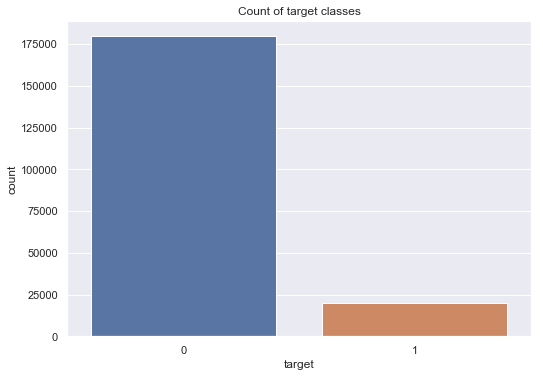

In [11]:
count_plot = sns.countplot(train_df["target"]).set_title("Count of target classes")
count_plot.get_figure().savefig(f"{img_path}/count_plot.png")

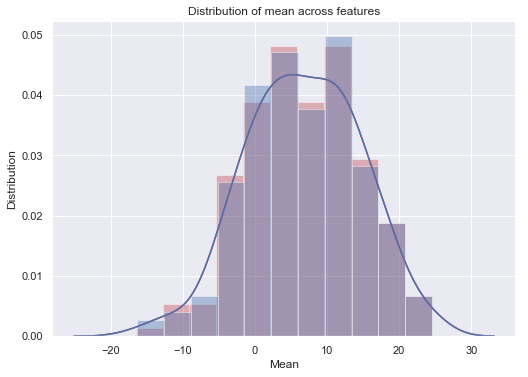

In [30]:
dist_mean_plot = sns.distplot(train_df[features].mean(), color="r", label="train")
dist_mean_plot = sns.distplot(test_df[features].mean(), color="b", label="test")
dist_mean_plot.set(xlabel="Mean", ylabel="Distribution", title="Distribution of mean across features")
dist_mean_plot.get_figure().savefig(f"{img_path}/dist_mean_plot.png")

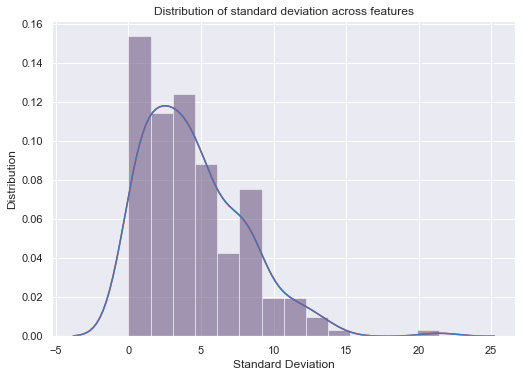

In [31]:
dist_sd_plot = sns.distplot(train_df[features].std(), color="r", label="train")
dist_sd_plot = sns.distplot(test_df.std(), color="b", label="test")
dist_sd_plot.set(xlabel="Standard Deviation", ylabel="Distribution", title="Distribution of standard deviation across features")
dist_sd_plot.get_figure().savefig(f"{img_path}/dist_sd_plot.png")

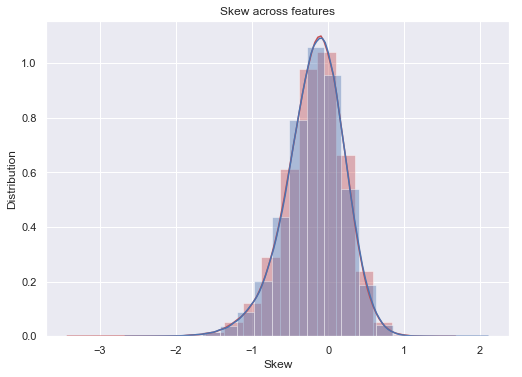

In [32]:
dist_skew_plot = sns.distplot(train_df[features].skew(axis="columns"), bins=20, color="r", label="train")
dist_skew_plot = sns.distplot(test_df.skew(axis="columns"), bins=20, color="b", label="test", )
dist_skew_plot.set(xlabel="Skew", ylabel="Distribution", title="Skew across features")
dist_skew_plot.get_figure().savefig(f"{img_path}/dist_skew_plot.png")

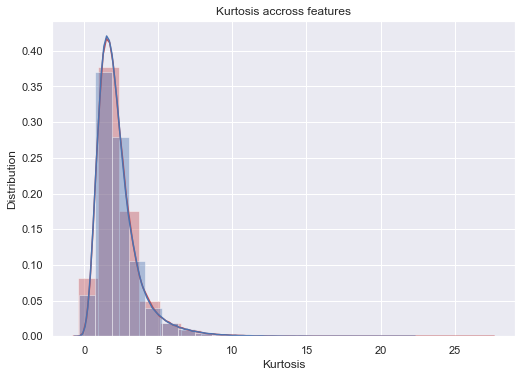

In [33]:
dist_kurt_plot = sns.distplot(train_df[features].kurt(axis="columns"), bins=20, color="r", label="train")
dist_kurt_plot = sns.distplot(test_df.kurt(axis="columns"), bins=20, color="b", label="test")
dist_kurt_plot.set(xlabel="Kurtosis", ylabel="Distribution", title="Kurtosis accross features")
dist_kurt_plot.get_figure().savefig(f"{img_path}/dist_kurt_plot.png")

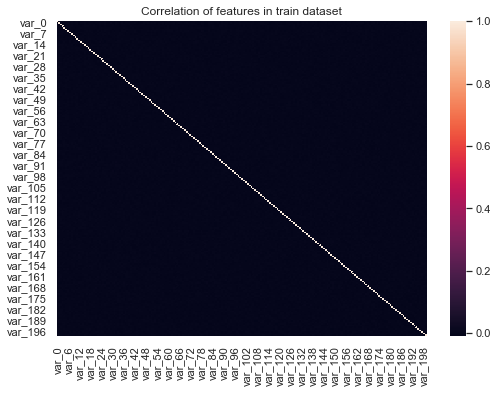

In [22]:
heatmap_corr_train = sns.heatmap(train_df[features].corr()).set_title("Correlation of features in train dataset")
heatmap_corr_train.get_figure().savefig(f"{img_path}/heatmap_corr_train.png")

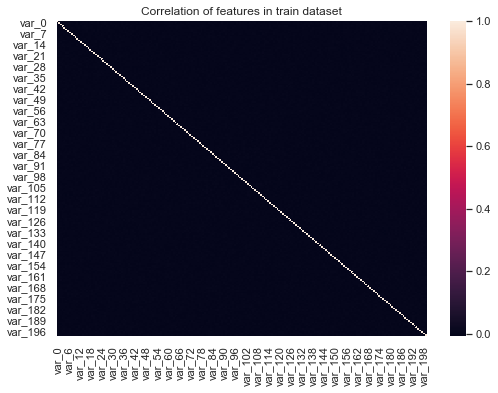

In [23]:
heatmap_corr_test = sns.heatmap(test_df.corr()).set_title("Correlation of features in train dataset")
heatmap_corr_test.get_figure().savefig(f"{img_path}/heatmap_corr_test.png")

## Feature Engineering
* Use `is_unblance` parameter from lightgbm/xgboost to deal with class imbalance instead of over/undersampling via [imblearn](https://github.com/scikit-learn-contrib/imbalanced-learn)

### Manual approach

In [4]:
def create_features(df: pd.DataFrame, funcs: list) -> pd.DataFrame:
    """
    Given an input dataframe, create additional features by applying each function in funcs.
    :param df: pandas dataframe to which each function in funcs is applied
    :param funcs: list of functions
    :return: pandas dataframe
    """
    for func in funcs:
        df[func] = df.apply(func, axis=1)
        
    return df

In [54]:
manual_features = ["sum", "max", "min", "mean", "median", "std", "skew", "kurt"]

In [16]:
train_df = create_features(df=train_df, funcs=eng_features)
test_df = create_features(df=test_df, funcs=eng_features)

In [17]:
train_df.shape

(200000, 209)

In [18]:
all_features = features + manual_features

### Using featuretools

In [6]:
entities = {
    "train": (train_df[features].reset_index(), "ID_code"),
    "test": (test_df.reset_index(), "ID_code")}

In [7]:
entity_set = ft.EntitySet("capstone", entities)

In [35]:
top10_features = [f"var_{i}" for i in (34, 165, 22, 121, 99, 133, 78, 53, 177, 6)]

In [61]:
trans_primitives = ["multiply_numeric", "divide_numeric"]
ignore_variables = {"train": [f for f in features if f not in top10_features]}
drop_exact = top10_features

In [77]:
feature_matrix, _ = ft.dfs(entityset=entity_set, target_entity="train", trans_primitives=trans_primitives, max_depth=1,
                       ignore_variables=ignore_variables, drop_exact=drop_exact, features_only=False, n_jobs=2)

In [80]:
feature_df = pd.concat([train_df[features], feature_matrix], axis="columns", sort=True)

/usr/local/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [81]:
feature_df.to_csv(f"{data_path}/feature_df.csv", chunksize=1000)

## Modeling
* Baseline model (lightGBM) based on original features
* Advanced model (lightGBM with learning-rate decay and grid search; XGBoost)
* ~~Deep-Learning model via fastai~~ (not feasible without GPU)

### Baseline Model

In [6]:
# set seed to reproduce results
random_state = 1337

In [7]:
# stratify split to guarantee same proportion of target labels in train and test
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df["target"], test_size=0.2, 
                                                    stratify=train_df["target"], random_state=random_state)

In [8]:
# create data container for lightgbm
train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=True)
valid_data = lgb.Dataset(X_test, label=y_test, free_raw_data=True)

In [9]:
# use default params from documentation with some exceptions: https://lightgbm.readthedocs.io/en/latest/Parameters.html
lgb_params = {
    "boosting": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "num_leaves": 31,
    "max_depth": -1,
    "learning_rate": 0.05, # 0.1
    "feature_fraction": 0.9, # 1.0
    "bagging_fraction": 0.8,  # 1.0
    "bagging_freq": 5,  # 0
    "is_unbalance": True,
    "n_jobs": 2,
    "verbosity": 1
}

In [13]:
# set number of iterations and early stopping
NUM_BOOST_ROUND = 1000
EARLY_STOPPING = 5
VERBOSE_EVAL = 50

In [14]:
# create dict to record results
lgb_evals_result = {}
lgb_watchlist = [train_data, valid_data]

In [15]:
# train model
gbm_baseline = lgb.train(params=lgb_params, train_set=train_data, valid_sets=lgb_watchlist, num_boost_round=NUM_BOOST_ROUND, 
                early_stopping_rounds=EARLY_STOPPING, evals_result=lgb_evals_result, verbose_eval=VERBOSE_EVAL)

Training until validation scores don't improve for 5 rounds.
[50]	training's auc: 0.865359	valid_1's auc: 0.824051
[100]	training's auc: 0.900565	valid_1's auc: 0.853628
[150]	training's auc: 0.919167	valid_1's auc: 0.867302
[200]	training's auc: 0.932121	valid_1's auc: 0.875848
[250]	training's auc: 0.941102	valid_1's auc: 0.881209
[300]	training's auc: 0.948127	valid_1's auc: 0.885368
[350]	training's auc: 0.953943	valid_1's auc: 0.888166
[400]	training's auc: 0.958807	valid_1's auc: 0.890282
[450]	training's auc: 0.962864	valid_1's auc: 0.891895
[500]	training's auc: 0.966463	valid_1's auc: 0.892994
[550]	training's auc: 0.969823	valid_1's auc: 0.893844
Early stopping, best iteration is:
[560]	training's auc: 0.97047	valid_1's auc: 0.893912


In [16]:
gbm_baseline.best_score

defaultdict(dict,
            {'training': {'auc': 0.9704695708081252},
             'valid_1': {'auc': 0.8939119024112345}})

In [17]:
# save model to disk
gbm_baseline.save_model(f"{model_path}/gbm_baseline_model.txt")

### Evaluate baseline model

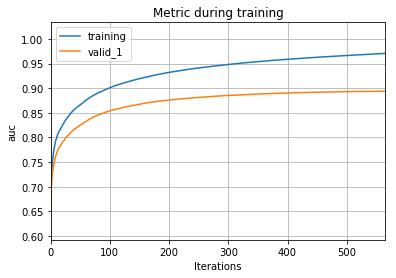

In [18]:
lgb.plot_metric(lgb_evals_result)

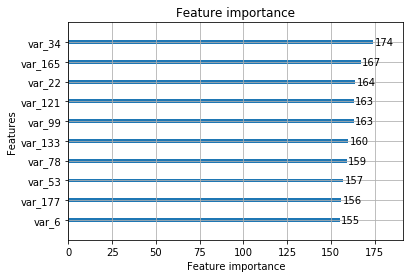

In [19]:
lgb.plot_importance(gbm_baseline, max_num_features=10)

## Advanced models

### Train lightgbm model with learning rate decay

In [113]:
# train model
gbm_decay = lgb.train(params=lgb_params, train_set=train_data, valid_sets=lgb_watchlist, num_boost_round=NUM_BOOST_ROUND, learning_rates=lambda iter: 0.1 * (0.99 ** iter),
                      early_stopping_rounds=EARLY_STOPPING, evals_result=lgb_evals_result, verbose_eval=VERBOSE_EVAL)

Training until validation scores don't improve for 5 rounds.
[50]	training's auc: 0.883206	valid_1's auc: 0.837181
[100]	training's auc: 0.90815	valid_1's auc: 0.857653
[150]	training's auc: 0.918536	valid_1's auc: 0.865012
[200]	training's auc: 0.92401	valid_1's auc: 0.869024
[250]	training's auc: 0.926811	valid_1's auc: 0.870879
[300]	training's auc: 0.928411	valid_1's auc: 0.871978
[350]	training's auc: 0.929394	valid_1's auc: 0.872619
[400]	training's auc: 0.929917	valid_1's auc: 0.872972
[450]	training's auc: 0.93025	valid_1's auc: 0.873189
[500]	training's auc: 0.930448	valid_1's auc: 0.873318
[550]	training's auc: 0.930571	valid_1's auc: 0.873408
[600]	training's auc: 0.93064	valid_1's auc: 0.873457
[650]	training's auc: 0.930686	valid_1's auc: 0.87349
[700]	training's auc: 0.930714	valid_1's auc: 0.873507
[750]	training's auc: 0.930731	valid_1's auc: 0.873519
[800]	training's auc: 0.930741	valid_1's auc: 0.873524
[850]	training's auc: 0.930747	valid_1's auc: 0.873529
Early stop

### Train lightgbm model on engineered features

In [134]:
feature_df = pd.read_csv(f"{data_path}/feature_df.csv")

In [135]:
feature_df.set_index("Unnamed: 0", inplace=True)

In [136]:
# split train data into train and validation datasets
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(feature_df, train_df["target"], test_size=0.2, stratify=train_df["target"], random_state=random_state)

In [137]:
# create data containers for lightgbm
train_data_eng = lgb.Dataset(X_train_eng, label=y_train_eng, free_raw_data=True)
valid_data_eng = lgb.Dataset(X_test_eng, label=y_test_eng, free_raw_data=True)

In [138]:
lgb_watchlist_eng = [train_data_eng, valid_data_eng]

In [139]:
lgb_evals_result_eng = {}

In [140]:
gbm_eng = lgb.train(params=lgb_params, train_set=train_data_eng, valid_sets=lgb_watchlist_eng, num_boost_round=NUM_BOOST_ROUND, 
                early_stopping_rounds=EARLY_STOPPING, evals_result=lgb_evals_result_eng, verbose_eval=VERBOSE_EVAL)

Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[8]	training's auc: 0.606012	valid_1's auc: 0.50821


### Use GridSearch with lightgbm model to find optimal learning rate

In [89]:
gbm_sklearn = lgb.LGBMClassifier(boosting_type=lgb_params["boosting"], 
                                 objective=lgb_params["objective"], 
                                 metric=lgb_params["metric"],
                                 is_unbalance=True, 
                                 colsample_bytree=lgb_params["feature_fraction"], 
                                 subsample=lgb_params["bagging_fraction"], 
                                 subsample_freq=lgb_params["bagging_freq"],
                                 random_state=random_state, 
                                 n_jobs=lgb_params["n_jobs"], 
                                 silent=False)

In [90]:
# create two pipes, one including scaling
lgb_pipe = Pipeline([("clf", gbm_sklearn)])
lgb_pipe_scaler = Pipeline([("scaler", RobustScaler()), ("clf", gbm_sklearn)])

In [91]:
param_grid = {
    "clf__learning_rate": [0.01, 0.05, 0.1],
}

In [92]:
lgb_gs = GridSearchCV(lgb_pipe, param_grid=param_grid, scoring="roc_auc", cv=N_FOLD, n_jobs=lgb_params["n_jobs"], verbose=lgb_params["verbosity"])

In [93]:
lgb_gs_scaler = GridSearchCV(lgb_pipe_scaler, param_grid=param_grid, scoring="roc_auc", cv=N_FOLD, n_jobs=lgb_params["n_jobs"], verbose=lgb_params["verbosity"])

#### Run pipe without scaler

In [94]:
lgb_gs = lgb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  2.1min finished


In [95]:
lgb_gs.best_params_

{'clf__learning_rate': 0.1}

In [96]:
lgb_gs.best_score_

0.8668709142935282

#### Run pipe with scaler

In [84]:
lgb_gs_scaler = lgb_gs_scaler.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:  3.7min finished


In [85]:
lgb_gs_scaler.best_params_

{'clf__learning_rate': 0.1}

In [86]:
lgb_gs_scaler.best_score_

0.8664526898745084

### Train XGBoost on standard features

In [20]:
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_valid = xgb.DMatrix(X_test, label=y_test)

/usr/local/anaconda3/envs/capstone/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [21]:
# use default params from documentation with some exceptions: https://xgboost.readthedocs.io/en/latest/parameter.html
xgb_params = {
    "boosting": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_leaves": 0,
    "max_depth": 6,
    "learning_rate": 0.05,
    "colsample_by_tree": 0.9,
    "scale_pos_weight": 9,
    "n_jobs": 2,
    "seed": random_state,
    "verbosity": 1
}

In [22]:
# create dict for eval_results
xgb_evals_result = {}
xgb_watchlist = [(xgb_train, "train"), (xgb_valid, "valid")]

In [23]:
# train model
xgb_model = xgb.train(params=xgb_params, dtrain=xgb_train, evals=xgb_watchlist, num_boost_round=NUM_BOOST_ROUND,
                      early_stopping_rounds=EARLY_STOPPING, evals_result=xgb_evals_result, verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.663361	valid-auc:0.640199
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 5 rounds.
[50]	train-auc:0.86317	valid-auc:0.79738
[100]	train-auc:0.910894	valid-auc:0.832398
[150]	train-auc:0.934975	valid-auc:0.848306
[200]	train-auc:0.95071	valid-auc:0.857673
[250]	train-auc:0.961759	valid-auc:0.864691
[300]	train-auc:0.96982	valid-auc:0.870032
[350]	train-auc:0.975872	valid-auc:0.873817
[400]	train-auc:0.980124	valid-auc:0.876413
[450]	train-auc:0.983856	valid-auc:0.878566
[500]	train-auc:0.986734	valid-auc:0.8804
Stopping. Best iteration:
[502]	train-auc:0.986845	valid-auc:0.880503



In [24]:
xgb_model.best_score

0.880503

### Evaluate XGBoost model

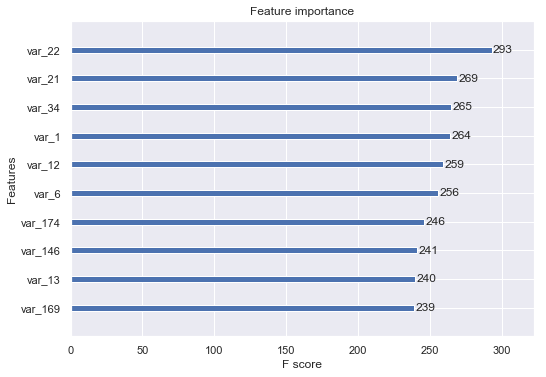

In [30]:
xgb.plot_importance(xgb_model, max_num_features=10)

In [37]:
xgb_model.save_model(f"{model_path}/xgb_model")

### Train XGBoost on engineered features

In [100]:
xgb_train_eng = xgb.DMatrix(X_train_eng, label=y_train_eng)
xgb_valid_eng = xgb.DMatrix(X_test_eng, label=y_test_eng)

In [102]:
xgb_evals_result_eng = {}
xgb_watchlist_eng = [(xgb_train_eng, "train"), (xgb_valid_eng, "valid")]

In [105]:
# train model
xgb_model_eng = xgb.train(params=xgb_params, dtrain=xgb_train_eng, evals=xgb_watchlist_eng, num_boost_round=NUM_BOOST_ROUND,
                      early_stopping_rounds=EARLY_STOPPING, evals_result=xgb_evals_result_eng, verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.534972	valid-auc:0.505723
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 5 rounds.
Stopping. Best iteration:
[6]	train-auc:0.589616	valid-auc:0.50858



In [106]:
xgb_model_eng.best_score

0.50858

## Prediction

As the baseline model yields the best results it is used for the final prediction

In [51]:
# load saved model from disk
model = lgb.Booster(model_file=f"{model_path}/gbm_baseline_model.txt")

In [52]:
# create predictions
test_pred = model.predict(test_df)

## Submission

In [54]:
sub_df = pd.DataFrame(test_pred, index=test_df.index, columns=["target"]).reset_index()

In [55]:
ts = pd.Timestamp.today().strftime("%Y_%m_%d")
sub_df.to_csv(f"{data_path}/submission_{ts}.csv", index=False)

In [56]:
!zip submission ./data/submission_2019_04_14.csv

  adding: data/submission_2019_04_14.csv (deflated 62%)


In [57]:
!kaggle competitions submit santander-customer-transaction-prediction -f submission.zip -m "Improved submission"

100%|███████████████████████████████████████| 2.26M/2.26M [00:05<00:00, 429kB/s]
Successfully submitted to Santander Customer Transaction Prediction